In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import numpy as np
from altair import *

In [2]:
chi = pd.read_csv('data/chicago/v2 07012017/ChicagoLicenseData.csv',low_memory=False)
chi = chi[(chi['LEGAL NAME'].str.contains('COFFEE|ROASTER')) |
          (chi['DOING BUSINESS AS NAME'].str.contains('COFFEE|ROASTER'))]
chi = chi[pd.DatetimeIndex(chi['LICENSE TERM EXPIRATION DATE']) >= '1/1/2017']
chi = chi.drop_duplicates(subset=['LOCATION'])
chi = chi.dropna(subset=['LOCATION'])
chi = chi[['LEGAL NAME','DOING BUSINESS AS NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP CODE','LATITUDE', 'LONGITUDE', 'LOCATION']]

# change into geodataframe
chi['geometry'] = chi.apply(lambda z: Point( z.LONGITUDE,z.LATITUDE), axis=1)
chi = gpd.GeoDataFrame(chi,crs = {'init': 'epsg:4326'})

In [3]:
ctaTrain = pd.read_csv('data/chicago/v2 07012017/trainStopsCTA.csv')
ctaTrain = ctaTrain[['Location','STATION_DESCRIPTIVE_NAME']].drop_duplicates(subset=['STATION_DESCRIPTIVE_NAME'])
ctaTrain[['LATITUDE','LONGITUDE']] = ctaTrain['Location'].str[1:-1].str.split(', ',expand=True).astype(float)
ctaTrain['geometry'] = ctaTrain.apply(lambda z: Point( z.LONGITUDE,z.LATITUDE), axis=1)
ctaTrain = gpd.GeoDataFrame(ctaTrain,crs = {'init': 'epsg:4326'})

In [4]:
ctaBus = gpd.read_file('data/chicago/v2 07012017/CTABusStops/CleanBusStops.shp',)

In [5]:
parks = pd.read_csv('data/chicago/v2 07012017/Chicago_parks/Parks_-_Map__deprecated_November_2016_.csv')
parks = parks[parks['PARK CLASS'].isin(['NEIGHBORHOOD PARK','COMMUNITY PARK', 'MAGNET PARK'])]
parks = parks[['PARK NAME','LOCATION']]
parks['LOCATION'] = parks['LOCATION'].replace('.+\n','',regex=True)
parks[['LATITUDE','LONGITUDE']] = parks['LOCATION'].str[1:-1].str.split(', ',expand=True).astype(float)
parks['geometry'] = parks.apply(lambda z: Point( z.LONGITUDE,z.LATITUDE), axis=1)
parks = gpd.GeoDataFrame(parks,crs = {'init': 'epsg:4326'})

In [6]:
def getNearestPoint(pt,searchPts):
    nearest = nearest_points(pt,searchPts.geometry.unary_union)[1]
    nearest = gpd.GeoDataFrame(searchPts[searchPts.geometry == nearest])
    name = nearest[nearest.columns[nearest.columns.str.contains('name|NAME|Name')]]
    x =name.iloc[0][0]
    y = nearest.geometry.distance(pt)
    if y.iloc[0] == 0.0:
        searchPts = searchPts.loc[[i for i in searchPts.index if i != nearest.index ],:]
        nearest = nearest_points(pt,searchPts.geometry.unary_union)[1]
        nearest = gpd.GeoDataFrame(searchPts[searchPts.geometry == nearest])
        name = nearest[nearest.columns[nearest.columns.str.contains('name|NAME|Name')]]
        x =name.iloc[0][0]
        y = nearest.geometry.distance(pt)
    try:
        y = float(y)
    except:
        y = 0.0
    return x,y

In [7]:
coffeeExtract = chi['geometry'].apply(lambda x: getNearestPoint(x,chi))
chi['nearestCoffeeDesc'] = coffeeExtract.apply(lambda x: x[0])
chi['nearestCoffeeDist'] = coffeeExtract.apply(lambda x: x[1])

In [8]:
trainExtract = chi['geometry'].apply(lambda x: getNearestPoint(x,ctaTrain))
chi['nearestTrainStopDesc'] = trainExtract.apply(lambda x: x[0])
chi['nearestTrainStopDist'] = trainExtract.apply(lambda x: x[1])

In [9]:
busExtract = chi['geometry'].apply(lambda x: getNearestPoint(x,ctaBus))
chi['nearestBusStopDesc'] = busExtract.apply(lambda x: x[0])
chi['nearestBusStopDist'] = busExtract.apply(lambda x: x[1])

In [10]:
parkExtract = chi['geometry'].apply(lambda x: getNearestPoint(x,parks))
chi['nearestParkDesc'] = parkExtract.apply(lambda x: x[0])
chi['nearestParkDist'] = parkExtract.apply(lambda x: x[1])

In [11]:
neighborhoods = gpd.read_file('data/chicago/v2 07012017/ChicagoNeighborhoods.shp')
neighborhoods['area'] = neighborhoods['geometry'].area

In [12]:
joinedData = pd.DataFrame(gpd.tools.sjoin(neighborhoods,chi,op='contains',how='inner'))

In [13]:
joinedData = joinedData[['pri_neigh','DOING BUSINESS AS NAME', 
            'ADDRESS','CITY', 'STATE', 'ZIP CODE',
            'nearestTrainStopDesc','nearestTrainStopDist','nearestBusStopDesc','nearestBusStopDist',
            'nearestCoffeeDesc','nearestCoffeeDist','nearestParkDesc','nearestParkDist'
                        ]].reset_index(drop=True)

In [14]:
joinedData['sbInd'] = joinedData['DOING BUSINESS AS NAME'].str.contains('STARBUCK')
joinedData['nearestTrainStopDesc'] = joinedData['nearestTrainStopDesc'].replace(to_replace=' \(.*\)',value='',regex=True)
joinedData = joinedData.reset_index()

In [15]:
joinedData.head(20)

,index,pri_neigh,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,nearestTrainStopDesc,nearestTrainStopDist,nearestBusStopDesc,nearestBusStopDist,nearestCoffeeDesc,nearestCoffeeDist,nearestParkDesc,nearestParkDist,sbInd
0,0,Grand Boulevard,ACE COFFEE BAR INC.,5001 S MICHIGAN AVE 1,CHICAGO,IL,60615,51st,0.004377,51st Street & Michigan,0.001629,DOLLOP HP LLC,0.025786,BAULER (MATHIAS),0.114322,False
1,1,Printers Row,PRINTER'S ROW COFFEE COMPANY LLC,600 S DEARBORN ST 7TH 712,CHICAGO,IL,60605,Harrison,0.001929,Dearborn & Harrison,0.000346,STARBUCKS CORPORATION,0.000343,BAULER (MATHIAS),0.043758,False
2,2,United Center,METRIC COFFEE CAFE,2021 W FULTON ST K101B,CHICAGO,IL,60612,Ashland,0.010789,Damen & Fulton,0.000845,INTELLIGENTSIA COFFEE INC.,0.003756,ERHLER (WILLIAM),0.030043,False
3,3,United Center,INTELLIGENTSIA COFFEE,1850 W FULTON ST,CHICAGO,IL,60612,Ashland,0.007150,Damen & Fulton,0.002791,"BOW & TRUSS, LLC",0.003150,ERHLER (WILLIAM),0.030684,False
4,4,United Center,BIG SHOULDERS COFFEE,324 N LEAVITT ST,CHICAGO,IL,60612,Western,0.013650,Grand & Leavitt,0.003259,Metric west fulton shop inc,0.004253,ERHLER (WILLIAM),0.028780,False
5,5,Sheffield & DePaul,STARBUCKS COFFEE #2494,1157 W WRIGHTWOOD AVE,CHICAGO,IL,60614,Diversey,0.006547,Fullerton & Racine,0.003445,STARBUCKS CORPORATION,0.004050,JONQUIL,0.004105,True
6,6,Sheffield & DePaul,STARBUCKS COFFEE #217,2200 N HALSTED ST 1ST,CHICAGO,IL,60614,Fullerton,0.005155,Halsted & Webster,0.000065,STARBUCKS CORPORATION,0.003273,CHURCHILL FIELD,0.000000,True
7,7,Little Village,LOS PEKES ICE CREAM & COFFEE SHOP INC.,4207 W 26TH ST 1ST,CHICAGO,IL,60623,Kostner,0.010305,26th Street & Keeler,0.000210,"ACE COFFEE BAR, INC.",0.034431,DOUGHERTY (DANIEL),0.081849,False
8,8,Little Village,ACE COFFEE BAR,2650 S CALIFORNIA AVE 2ND,CHICAGO,IL,60608,California,0.011126,Cook County Criminal Court,0.000529,CHICAGO HOPE ACADEMY,0.024981,ERHLER (WILLIAM),0.074187,False
9,9,Calumet Heights,THOMAS COFFEE SHOP,1657 E 87TH ST,CHICAGO,IL,60617,87th,0.041796,87th Street & East End,0.000060,STARBUCKS CORPORATION,0.029231,BAULER (MATHIAS),0.188990,False


In [16]:
# aggFuncs = {'index':'count','nearestTrainStopDist':'mean','nearestBusStopDist':'mean','nearestCoffeeDist':'mean'}
aggFuncs = {'index':'count','nearestTrainStopDist':'mean','nearestCoffeeDist':'mean','nearestParkDist':'mean'}

In [17]:
sb = joinedData[joinedData['sbInd']==True].groupby('pri_neigh').agg(aggFuncs).reset_index()
not_sb = joinedData[joinedData['sbInd']==False].groupby('pri_neigh').agg(aggFuncs).reset_index()

nsbRatios = sb.merge(not_sb,how='left',on='pri_neigh',suffixes=['_sb','_nsb'])
nsbRatios = nsbRatios.fillna(0)
nsbRatios['nsbRatio'] = nsbRatios['index_nsb']/nsbRatios['index_sb']

In [18]:
nsbRatios.sort_values('nsbRatio',ascending=False).head(10)

,pri_neigh,nearestCoffeeDist_sb,nearestParkDist_sb,index_sb,nearestTrainStopDist_sb,nearestCoffeeDist_nsb,nearestParkDist_nsb,index_nsb,nearestTrainStopDist_nsb,nsbRatio
17,Logan Square,0.004167,0.003764,1,0.000000,0.004094,0.005366,8.0,0.002107,8.0
34,West Town,0.000829,0.025022,1,0.005480,0.004246,0.021733,7.0,0.008623,7.0
8,Edgewater,0.010704,0.049128,1,0.001554,0.002762,0.056592,4.0,0.004842,4.0
16,Lincoln Square,0.004568,0.024040,2,0.002089,0.003956,0.031864,6.0,0.005074,3.0
35,Wicker Park,0.000853,0.008180,1,0.000540,0.004183,0.010101,3.0,0.005186,3.0
13,Hyde Park,0.005777,0.129035,2,0.021987,0.001271,0.132528,5.0,0.014643,2.5
4,Boystown,0.001523,0.017254,1,0.009095,0.002895,0.018635,2.0,0.007175,2.0
7,East Village,0.002072,0.018526,1,0.003473,0.002512,0.020610,2.0,0.005347,2.0
21,North Center,0.002774,0.007512,3,0.007262,0.002226,0.009726,6.0,0.005573,2.0
31,Uptown,0.003729,0.033139,2,0.002389,0.003973,0.036413,3.0,0.003522,1.5


In [19]:
def getSBDensity(x):
    if x.index_sb == 0:
        return 0.0
    else:
        return x.area / x.index_sb
        
def getNSBDensity(x):
    if x.index_nsb ==0:
        return 0.0
    else:
        return x.area / x.index_nsb
        
def getCoffeeDensity(x):
    if (x.index_nsb + x.index_sb ) ==0:
        return 0.0
    else:
        return x.area / (x.index_nsb + x.index_sb)

In [25]:
nsbRatios = nsbRatios.merge(neighborhoods[['pri_neigh','area']])
nsbRatios['areaPerSB'] = nsbRatios.apply(getSBDensity,axis=1)
nsbRatios['areaPerNSB'] = nsbRatios.apply(getNSBDensity,axis=1)
nsbRatios['areaPerCoffee'] = nsbRatios.apply(getCoffeeDensity,axis=1)
#nsbRatios.drop('area',axis=1,inplace=True)
nsbRatios.head()

,pri_neigh,nearestCoffeeDist_sb,nearestParkDist_sb,index_sb,nearestTrainStopDist_sb,nearestCoffeeDist_nsb,nearestParkDist_nsb,index_nsb,nearestTrainStopDist_nsb,nsbRatio,areaPerSB,areaPerNSB,areaPerCoffee,area
0,Albany Park,0.006013,0.039140,2,0.008307,0.006013,0.039068,2.0,0.006201,1.0,0.000270,0.000270,0.000135,0.000540
1,Andersonville,0.004972,0.039809,1,0.009828,0.001469,0.044625,1.0,0.009682,1.0,0.000097,0.000097,0.000048,0.000097
2,Belmont Cragin,0.002069,0.074497,2,0.043445,0.020678,0.044437,2.0,0.028794,1.0,0.000550,0.000550,0.000275,0.001100
3,Beverly,0.023791,0.210110,1,0.000000,0.023791,0.188951,1.0,0.054787,1.0,0.000892,0.000892,0.000446,0.000892
4,Boystown,0.001523,0.017254,1,0.009095,0.002895,0.018635,2.0,0.007175,2.0,0.000034,0.000017,0.000011,0.000034


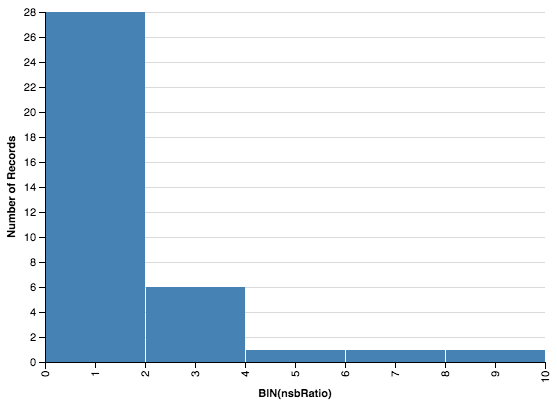

In [26]:
Chart(nsbRatios[['nsbRatio']]).mark_bar().encode(
    x=X('nsbRatio',
        bin=Bin(maxbins=5.0,),
       ),
    y='count(*)',
)

In [27]:
nsbRatios.to_csv('chicago_ratios_081117.csv',index=False)

In [28]:
nsbRatios.shape

(37, 14)